In [16]:
import pandas as pd

from src.models.time_series_model import TimeSeriesModel
from src.special_preprocessing.second_special_pipeline.pipeline import preprocessing_pipeline
from src.utils import train_test_split_by_months
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from src.metrics.forecast_accuracy import forecast_accuracy

In [17]:
X = pd.read_csv("../datasets/second_dataset/week_sales.csv", parse_dates=["date"], index_col=False)
X_ans = pd.read_csv("../datasets/second_dataset/week_sales_ans.csv", parse_dates=["date"], index_col=False)
X = X[(X["CUSTOMER_CODE"] == "customer2") & (X["date"] < pd.Timestamp("2019-01-01"))]
X_ans = X_ans[(X_ans["channel"] == "customer2") & (X_ans["date"] < pd.Timestamp("2019-01-01"))]

In [18]:
X_marked = train_test_split_by_months(X, date_column="date", test_months=3)
X_marked_ans = train_test_split_by_months(X_ans, date_column="date", test_months=3)

In [19]:
from configs.models_configs import ModelsConfigs
from configs.models_collector import ModelsCollector

selector = ModelsCollector(ModelsConfigs)
trend_models = selector.get_configs(["KNeighborsRegressor", "SVR"])
seasonal_models = selector.get_configs(["XGBRegressor", "GradientBoostingRegressor"])
tscv = TimeSeriesSplit(n_splits=4)
model = TimeSeriesModel(trend_models, seasonal_models, cv=tscv, scoring="neg_mean_squared_error")

In [20]:
tsm_pipeline = Pipeline(steps=[("preprocessing", preprocessing_pipeline), ("TSM", model)])
tsm_pipeline.fit(X_marked)

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('rename', RenameColumns()),
                                 ('key', KeyTransformer()),
                                 ('discount', DiscountTransformer()),
                                 ('fill_data_range',
                                  DateRangeFilledTransformerSec()),
                                 ('categorical_features_prep',
                                  CategoricalFeaturesTransform()),
                                 ('features extraction',
                                  FeatureExtractionTransformer()),
                                 ('decomposition',
                                  SeriesDecompositionTransformer...
                                                  (<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>,
                                                   {'learning_rate': array([0.01      , 0.03162278, 0.1       ]),
                                                    'max_depth': [3, 5, 7]})],
                                 trend_models=[(<class 'sklearn.neighbors._regression.KNeighborsRegressor'>,
                                                {'n_neighbors': [3, 5, 10,
                                                                 15]}),
                                               (<class 'sklearn.svm._classes.SVR'>,
                                                {'C': array([  0.1,   1. ,  10. , 100. ]),
                                                 'epsilon': array([0.01      , 0.17333333, 0.33666667, 0.5       ])})]))])

In [21]:
result = tsm_pipeline.predict(X_marked)

In [22]:
forecast_df = pd.merge(result[["date", "key", "Forecast"]], X_marked_ans[X_marked_ans["mark"] == "test"][["date", "key", "ship"]], on=["date", "key"])
forecast_df["key"] = pd.factorize(forecast_df["key"])[0]
forecast_df = forecast_df.rename(columns={"ship": "Actual"})

In [23]:
forecast_df

,date,key,Forecast,Actual
0,2018-10-01,0,1.365841,8.590695
1,2018-10-08,0,1.365295,3.245374
2,2018-10-15,0,1.364952,22.081267
3,2018-10-22,0,1.364758,3.245374
4,2018-10-29,0,1.364423,4.008991
...,...,...,...,...
23455,2018-12-20,273,0.380823,0.000000
23456,2018-12-21,273,0.380978,0.000000
23457,2018-12-22,273,0.381130,0.000000
23458,2018-12-23,273,3.624388,0.000000


In [24]:
forecast_accuracy(forecast_df, time_period="YE")

,date,Forecast,Actual,AE,Acc
0,2018-12-31,1.325557e+06,1.331992e+06,6434.828318,0.995169


In [25]:
forecast_accuracy(forecast_df, time_period="ME")

,date,Forecast,Actual,AE,Acc
0,2018-10-31,484424.592715,452536.067866,31888.524848,0.929534
1,2018-11-30,505354.750909,490464.674424,14890.076485,0.969641
2,2018-12-31,335777.849539,388991.279191,53213.429651,0.863201


In [26]:
forecast_accuracy(forecast_df, time_period="YE", ae_gr_cols=["key"])

,date,key,Forecast,Actual,AE,Acc
0,2018-12-31,0,66.147137,129.114961,62.967824,0.512312
1,2018-12-31,1,626.690278,714.749566,88.059288,0.876797
2,2018-12-31,2,219.689932,196.311640,23.378292,0.880912
3,2018-12-31,3,2866.844073,2591.490885,275.353188,0.893747
4,2018-12-31,4,273.967244,149.873366,124.093878,0.172008
...,...,...,...,...,...,...
271,2018-12-31,271,19633.715379,31643.376115,12009.660736,0.620468
272,2018-12-31,272,9533.172236,9182.048529,351.123708,0.961760
273,2018-12-31,273,149.656888,59.329497,90.327390,-0.522470
274,2018-12-31,274,2.509789,0.000000,2.509789,0.000000


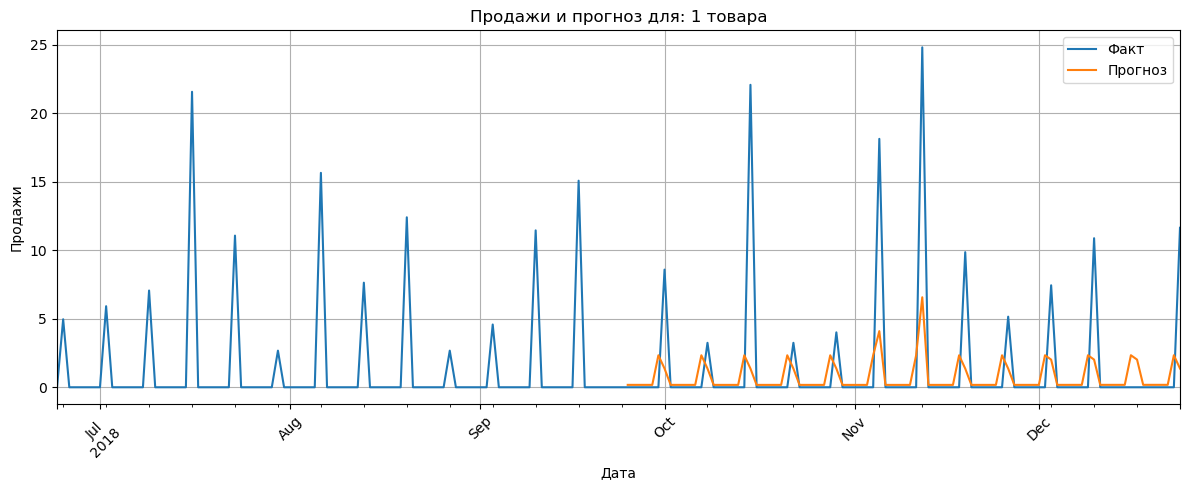

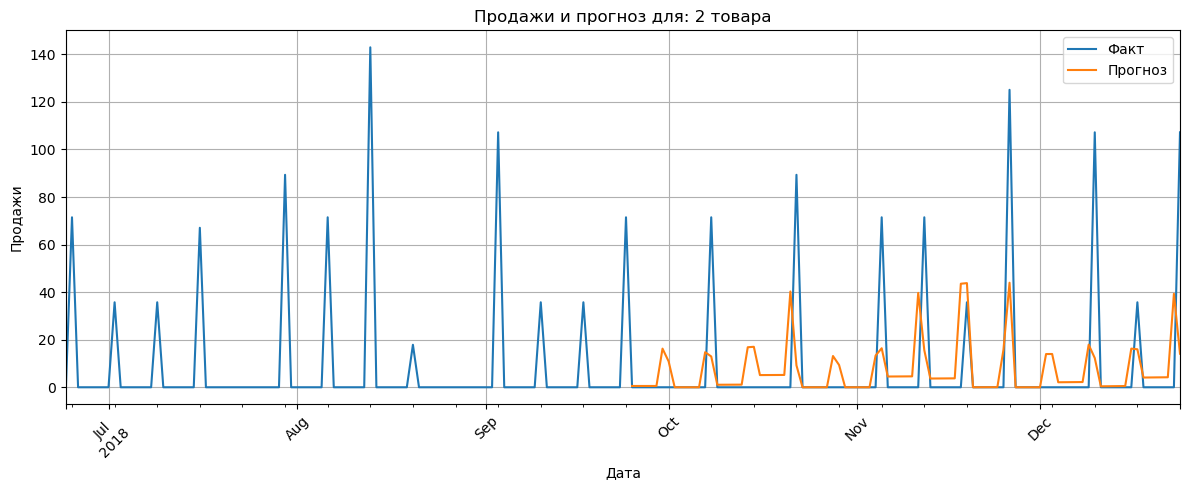

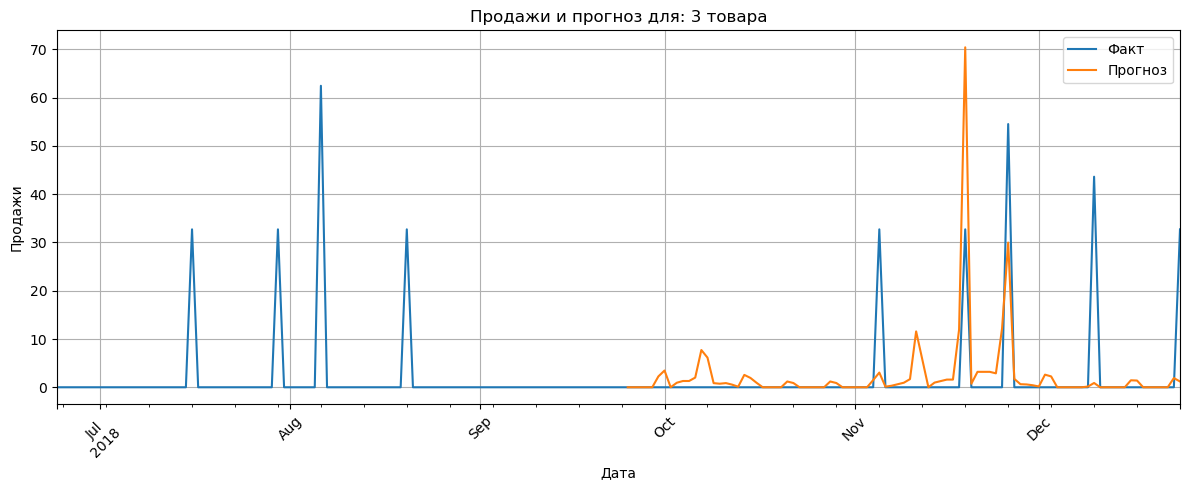

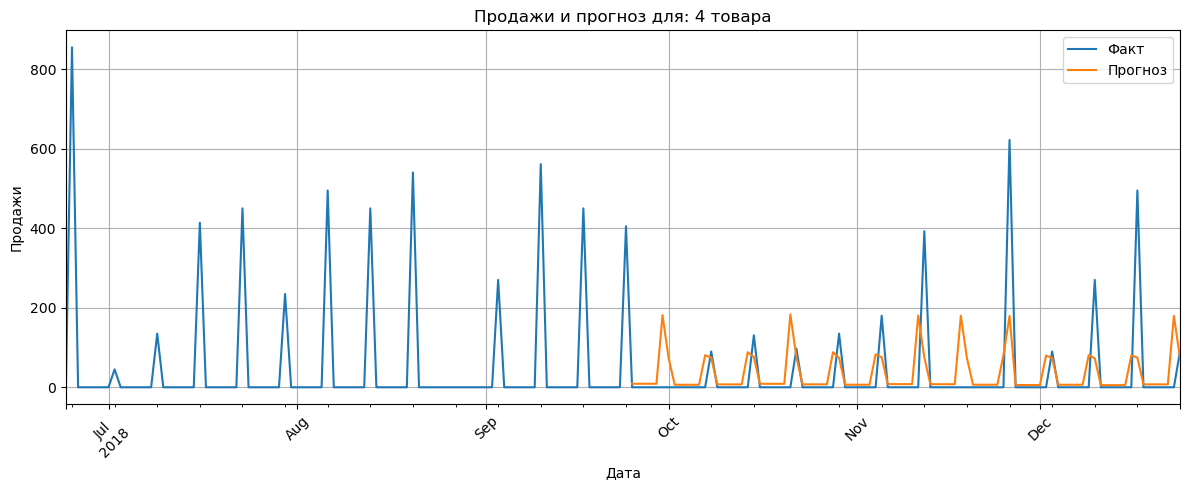

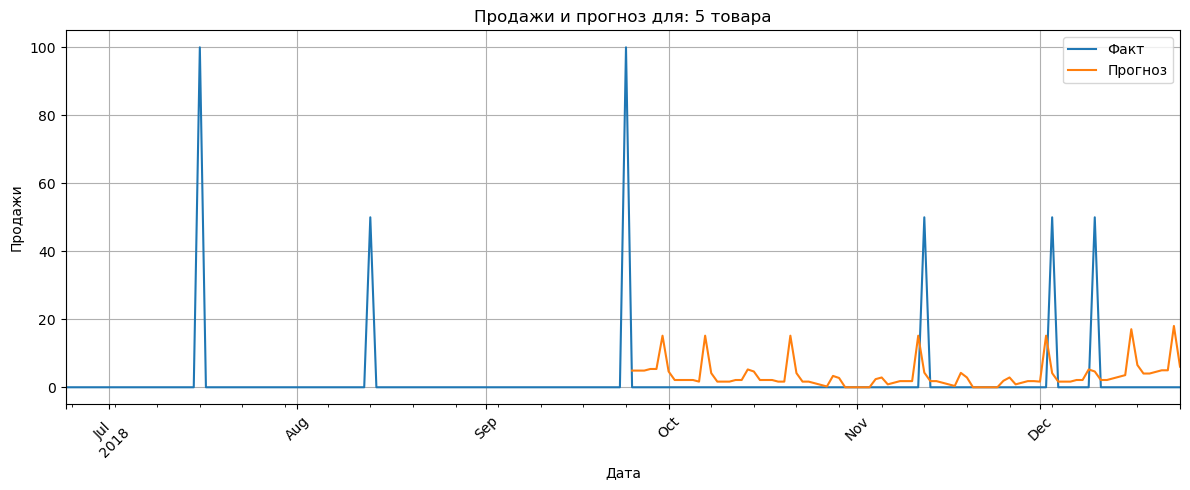

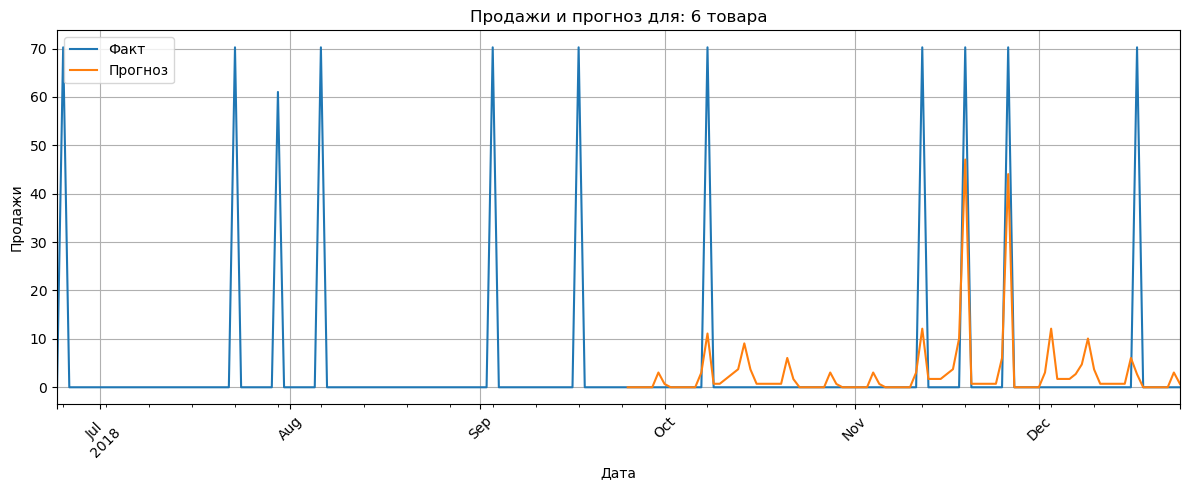

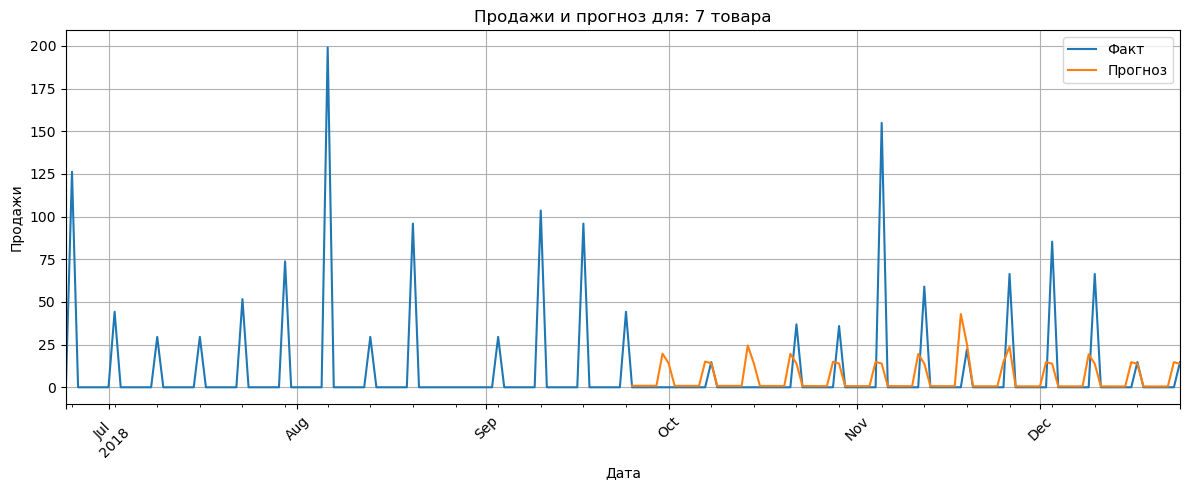

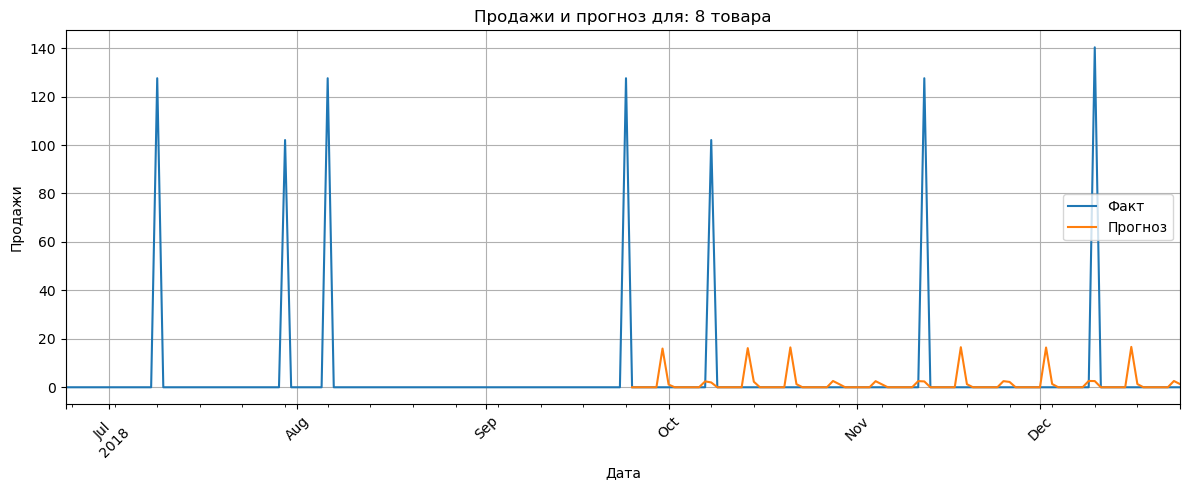

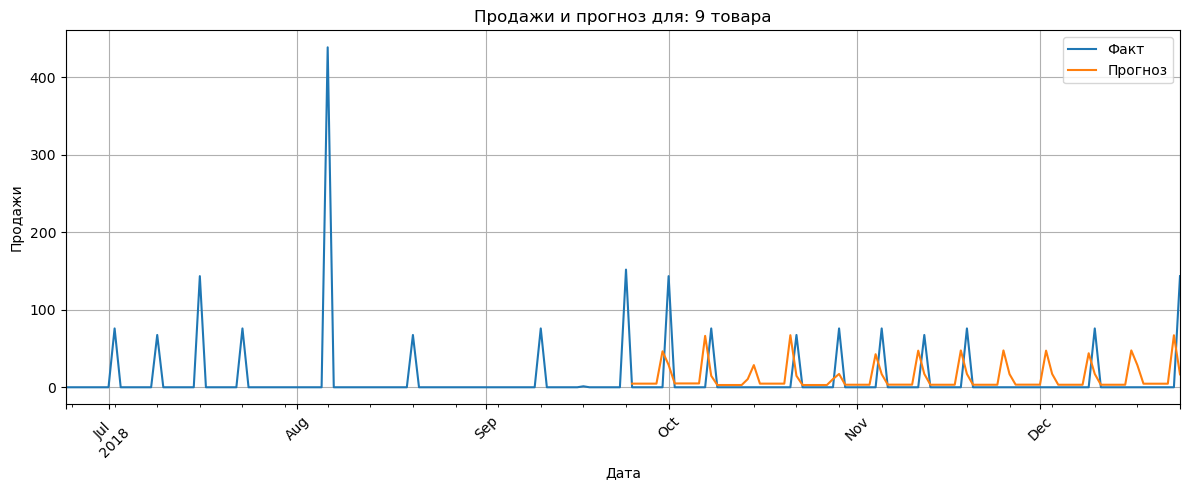

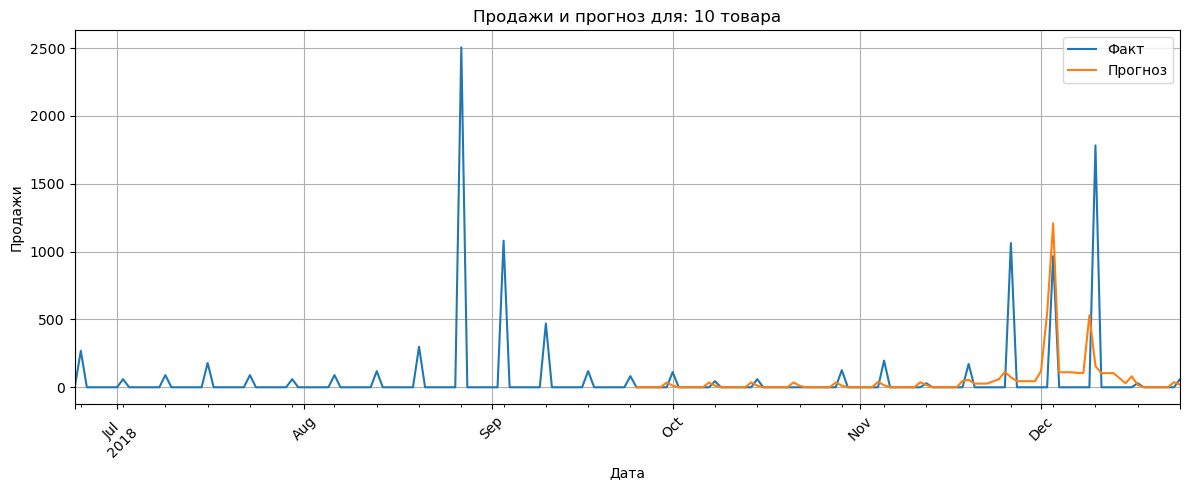

In [27]:
import matplotlib.pyplot as plt

keys = result["key"].unique()[:10]

for idx, key in enumerate(keys, 1):
    pred_key_df = result[result["key"] == key]
    last_pred_date = pred_key_df["date"].max()
    start_date = last_pred_date - pd.DateOffset(months=6)

    real_key_df = X_ans[(X_ans["key"] == key) & (X_ans["date"] >= start_date) & (X_ans["date"] <= last_pred_date)]

    pred_key_df = result[result["key"] == key]

    combined_df = pd.merge(
        real_key_df[["date", "key", "ship"]], pred_key_df[["date", "key", "Forecast"]], on=["date", "key"], how="outer"
    )

    combined_df = combined_df.sort_values("date").set_index("date")

    combined_df[["ship", "Forecast"]].plot.line(figsize=(12, 5), title=f"Продажи и прогноз для: {idx} товара")
    plt.xlabel("Дата")
    plt.ylabel("Продажи")
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.legend(["Факт", "Прогноз"])
    plt.tight_layout()
    plt.show()